Author: Keita Watanabe

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
sns.set_context("talk")
sns.set(style="ticks", font_scale=1.5)
%matplotlib inline

Contents in this notebook:
* (Some) Optimization methods
    * Steepest Descent
    * Newton's method
    * Gauss Newton's method
* Basics of Digital Filter
* Inverse Filter
    * Various kinds of Inversre Filter
        * Winer Filter
            * LMS algorithm
            * Analysis of LMS algorithm
            * Computer Experiments

# (Some) Optimization methods

In [71]:
class Func(object):
    def __init__(self, step=1e-04):
        self.step = step
    def val(self, x, y):
        return(
            3* x ** 2 + 5 * y ** 2 - 6 * x * y
        )
    def dx(self, x, y):
        return(
            (self.val(x+self.step, y) - self.val(x-self.step, y)) / (2*self.step)
        )
    def dy(self, x, y):
        return(
            (self.val(x, y+self.step) - self.val(x, y-self.step)) / (2*self.step)
        )
    def dxx(self, x, y):
        return(
            (self.dx(x+self.step, y) - self.dx(x-self.step, y)) / (2*self.step)
        )
    def dyy(self, x, y):
        return(
            (self.dy(x, y+self.step) - self.dy(x, y-self.step)) / (2*self.step)
        )
    def dxy(self, x, y):
        return(
            (self.dx(x, y+self.step) - self.dx(x, y-self.step)) / (2*self.step)
        )
    def grad(self, pos):
        return(np.array([self.dx(*pos), self.dy(*pos)]))
    def hessian(self, x, y):
        H = np.zeros((2, 2))
        H[0, 0] = self.dxx(x, y); H[1, 0] = self.dxy(x, y); H[0, 1] = self.dxy(x, y); H[1, 1] = self.dyy(x, y)
        return(H)

In [72]:
# set graph range
til = 10
x1_min  = -til
x1_max = til
x2_min= -til
x2_max = til

# set field
npoints = 1000
X = np.linspace(x1_min, x1_max, npoints)
Y = np.linspace(x2_min, x2_max, npoints)
mu = np.array([0, 0])
cov = np.array([[2.5,  1.4],
       [1.4,  5.8]])
func = Func()
E = np.zeros((npoints, npoints))
for row, x in enumerate(X):
    for col, y in enumerate(Y):
        E[row, col] = func.val(x, y)
X, Y = np.meshgrid(X, Y)        

(-10, 10)

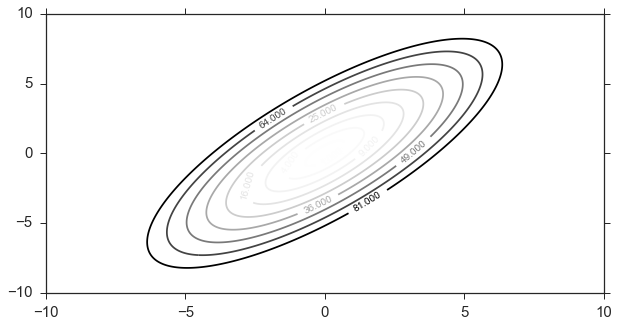

In [73]:
interval = [x**2 for x in range(10)]
fig, ax = plt.subplots(figsize=(10, 5))
CS = ax.contour(X, Y, E, interval)
ax.clabel(CS, inline=1)
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)

## Method of Steepest Descent

In [74]:
def steepest_descent(func, x0, y0, eta=0.001, maxiter=1e+04, tol=1.48e-08):
    pos = np.array([x0, y0])
    pos_prev = pos.copy() - 1
    poss = list(); poss.append(pos.copy())
    for _ in range(int(maxiter)):
        if np.abs(func.val(*pos) - func.val(*pos_prev)) <= tol:
            print("Total number of iterations: ", _)
            return(np.array(poss))
        pos_prev = pos.copy()
        pos -= eta*func.grad(pos)
        poss.append(pos.copy())
    sys.stderr.write("Maximum number of iterations exceeded!")
    return(np.array(poss))

Total number of iterations:  38102


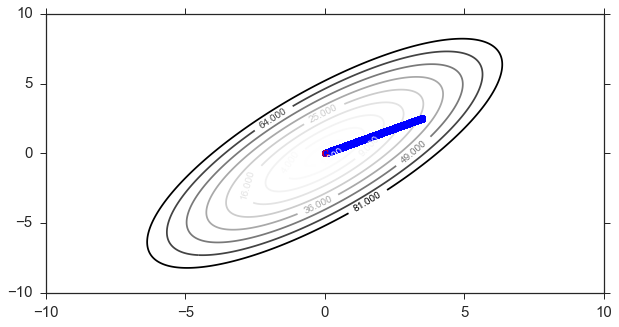

In [75]:
x0, y0 = 3.5, 2.5
poss = steepest_descent(func, x0, y0, eta=1e-04, maxiter=int(1e+05))
fig, ax = plt.subplots(figsize=(10, 5))
CS = ax.contour(X, Y, E, interval)
ax.clabel(CS, inline=1)
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)
ax.plot(poss[0, 0], poss[0, 1], color="r", marker="$\mathbf{S}$")
ax.plot(poss[:, 0], poss[:, 1], "b-o")
ax.plot(poss[-1, 0], poss[-1, 1], color="r", marker="$\mathbf{G}$")

Total number of iterations:  45


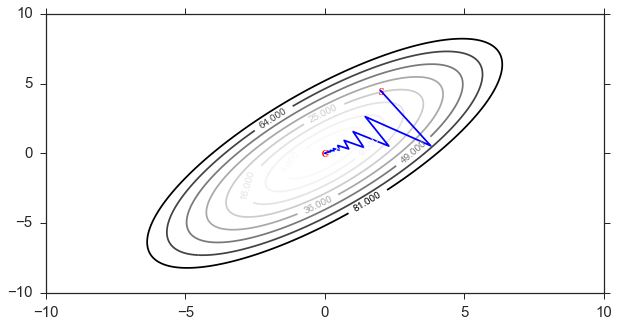

In [76]:
x0, y0 = 2., 4.5
poss = steepest_descent(func, x0, y0, eta=1.2e-01)
fig, ax = plt.subplots(figsize=(10, 5))
CS = ax.contour(X, Y, E, interval)
ax.clabel(CS, inline=1)
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)
ax.plot(poss[0, 0], poss[0, 1], color="r", marker="$\mathbf{S}$")
ax.plot(poss[:, 0], poss[:, 1], "b-")
ax.plot(poss[-1, 0], poss[-1, 1], color="r", marker="$\mathbf{G}$")

Maximum number of iterations exceeded!

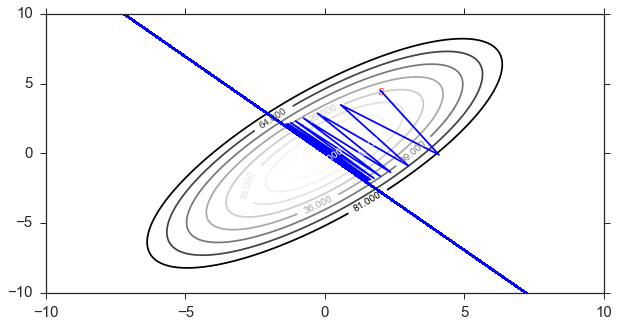

In [77]:
x0, y0 = 2., 4.5
poss = steepest_descent(func, x0, y0, eta=1.396433e-01)
fig, ax = plt.subplots(figsize=(10, 5))
CS = ax.contour(X, Y, E, interval)
ax.clabel(CS, inline=1)
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)
ax.plot(poss[0, 0], poss[0, 1], color="r", marker="$\mathbf{S}$")
ax.plot(poss[:, 0], poss[:, 1], "b-")
ax.plot(poss[-1, 0], poss[-1, 1], color="r", marker="$\mathbf{G}$")

## Newton's Method

In [62]:
def newton(func, x0, y0, eta=0.001, maxiter=1e+06, tol=1.48e-08):
    pos = np.array([x0, y0])
    pos_prev = pos.copy() - 1
    poss = list(); poss.append(pos.copy())
    H_inv = np.zeros((2, 2))
    for _ in range(int(maxiter)):
        if np.abs(func.val(*pos) - func.val(*pos_prev)) <= tol:
            print("Total number of iterations: ", _)
            return(np.array(poss))
        pos_prev = pos.copy()
        H = func.hessian(*pos)
        det = H[0, 0] * H[1, 1] - H[1, 0] * H[0, 1]
        if det == 0:
            raise RuntimeError("The determinant of the Hessian is 0! Cannot calculate inverse...")
        H_inv[0, 0] = H[1, 1]; H_inv[1, 0] = -H[1, 0]; H_inv[0, 1] = -H[0, 1]; H_inv[1, 1] = H[0, 0];
        H_inv /= det
        pos -= np.dot(H_inv, func.grad(pos))
        poss.append(pos.copy())
    sys.stderr.write("Maximum number of iterations exceeded!")
    return(np.array(poss))

Total number of iterations:  2


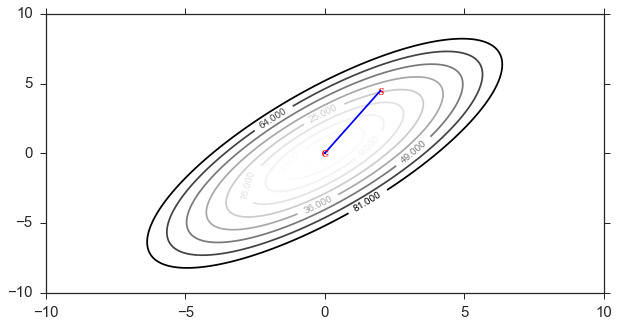

In [11]:
x0, y0 = 2., 4.5
poss = newton(func, x0, y0)
fig, ax = plt.subplots(figsize=(10, 5))
CS = ax.contour(X, Y, E, interval)
ax.clabel(CS, inline=1)
ax.set_xlim(x1_min, x1_max)
ax.set_ylim(x2_min, x2_max)
ax.plot(poss[0, 0], poss[0, 1], color="r", marker="$\mathbf{S}$")
ax.plot(poss[:, 0], poss[:, 1], "b-")
ax.plot(poss[-1, 0], poss[-1, 1], color="r", marker="$\mathbf{G}$")

# Least Square Filter

# Wiener Filter

In [12]:
class LMS(object):
    """LMS Filter with linear neuron model
    It's just a perceptron. The weights is updated by stochastic gradient descent algorithm(SGD).
    
    Parameters
    ------------------------------------------------------------------------
    eta: float
        Learning rate
    
    Attributes
    ------------------------------------------------------------------------
    w_: 1-d array
        Weights after fitting
    errors_: list
        brabra
    """
    def __init__(self, eta=0.01, cal_error=False):
        self.eta = 0.01
        self.w_ = None
        self.w_initialized = False
        self.cal_error = cal_error
        self.errors = None
        if self.cal_error:
            self.errors = []
            
    def fit(self, X, y):
        """Fit training data
        input:
        X: data. n rows(number of data points) and m columns(features)
        y: desired responses(labels). n rows
        output:
        w: (m) rows learned weights of a separatorixs
        eta: learning rate
        """
        # add a column for bias parameter (enable it when you want biases)
        # X = np.c_[np.ones(X.shape[0]), X]
        n, m = X.shape
        self.w_ = np.zeros(m); self.w_initialized = True
        for i, (x, target) in enumerate(zip(X, y)):
            e = target - np.dot(self.w_.T, x)
            self.w_ += self.eta*e*x
            if self.cal_error:
                self.errors.append(((target - np.dot(self.w_.T, x))**2)[0])
#                 self.errors.append(self._cal_error(X, y, i))
        return self
    def predict(self, X):
        # add a column for bias parameter (enable it when you want biases)
        # X = np.c_[np.ones(X.shape[0]), X]
        return(np.dot(X, self.w_))
    
    def _cal_error(self, X, y, i):
        return(np.sum((y[:i] - np.dot(X[:i], self.w_).reshape(len(X[:i]), 1))**2)/len(X[:i]))
    

# Computer Experiment I: Linear Prediction

In this experiment, we consider a generative model defined by
$$
x(n) = ax(n-1) + \epsilon(n) \quad \epsilon(n) \sim \mathscr{N}(0, \sigma^2_{\epsilon})
$$

* $a = 0.99$
* $\sigma^2_{\epsilon}=0.02$
* $x(0) = 1$

In [18]:
a = 0.99
niter = 5000
def xn_gen(var=0.02):
    xn = 1; yield xn
    while True:
        xn = a*xn + np.random.normal(loc=0, scale=np.sqrt(var))
        yield xn

In [19]:
xn_gen_ = xn_gen();
xn = np.array([next(xn_gen_) for _ in range(niter-1)])

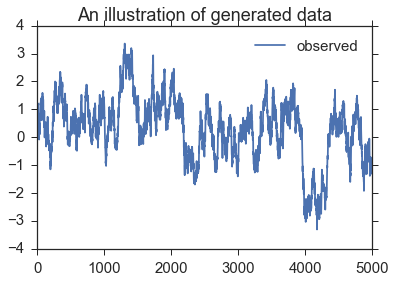

In [20]:
plt.title("An illustration of generated data")
plt.plot(xn, label="observed")
plt.legend(loc="best")

In [21]:
niter = 5000
navg = 100
errors = np.zeros(niter-1) 
for _ in range(navg):
    xn_gen_ = xn_gen(var=2*1e-03)
    xn = np.array([next(xn_gen_) for _ in range(niter)])
    lms = LMS(eta=1e-04, cal_error=True)
    X = xn[0:-1].reshape(len(xn)-1, 1).copy()
    y = xn[1:].reshape(len(xn)-1, 1).copy()
#     y = dn.reshape(len(dn), 1).copy()
    lms.fit(X, y)
    errors += np.array(lms.errors)
errors /= navg

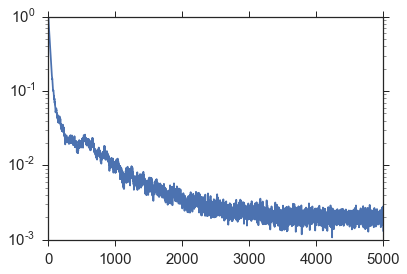

In [22]:
plt.plot(errors)
plt.yscale("log")#; plt.ylim(10**(-2), 10)

# Application: Kaggle House Prices Prediction competition
You can download the data and description from [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

In [23]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

In [24]:
train = pd.read_csv("../data/HousePrices/train.csv")
test = pd.read_csv("../data/HousePrices/test.csv")

In [25]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Select Features

In [26]:
selected_features = ["YearBuilt", "GarageArea", "1stFlrSF", "YearRemodAdd", "TotalBsmtSF"]
X, y = train.loc[:, selected_features], train.loc[:, ["SalePrice"]]
# Preprosessing: Fill NaN with mean
X = X.fillna(X.mean())

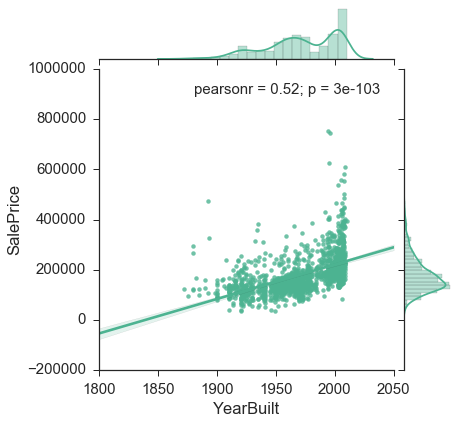

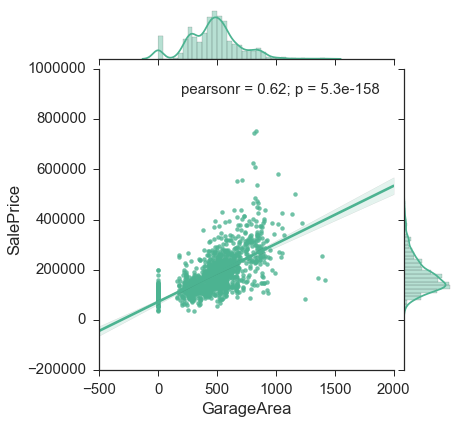

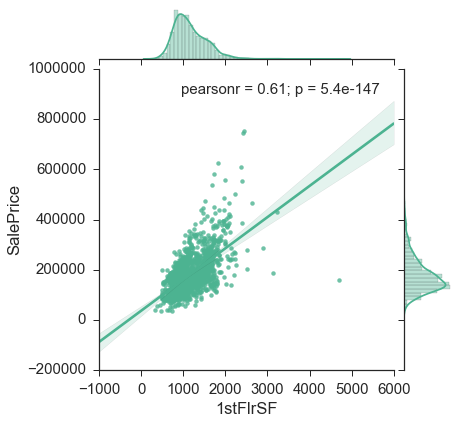

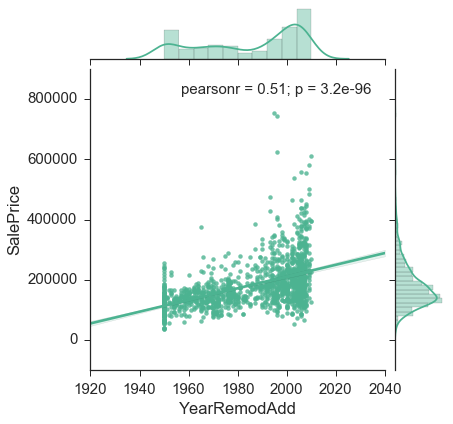

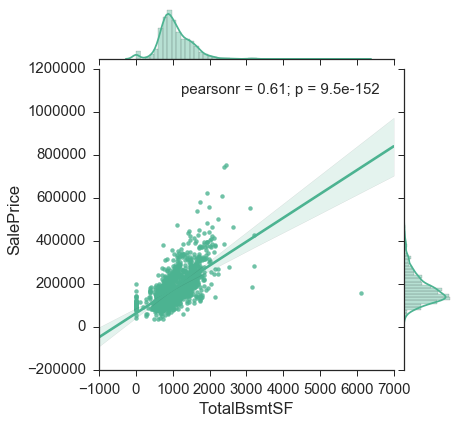

In [27]:
# check whether each feature is correlates to the target variable
for feature in selected_features:
    sns.jointplot(X[feature], y["SalePrice"], kind="reg", color="#4CB391")

In [28]:
X, y = np.array(X), np.array(y)

In [31]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

ImportError: cannot import name '_safe_split'

In [33]:
X = preprocessing.scale(X); y = preprocessing.scale(y)

/Users/watanabekeita/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  if n_features < ensure_min_features:
/Users/watanabekeita/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  if n_features < ensure_min_features:


In [ ]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25, random_state=0)

## Modify LMS estimator

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
class LMS(BaseEstimator, RegressorMixin):
    """LMS Filter with linear neuron model
    It's just a perceptron. The weights is updated by stochastic gradient descent algorithm(SGD).
    
    Parameters
    ------------------------------------------------------------------------
    eta: float
        Learning rate
    
    Attributes
    ------------------------------------------------------------------------
    w_: 1-d array
        Weights after fitting
    """
    def __init__(self, eta=0.01):
        self.eta = eta
        self.w_ = None
            
    def fit(self, X, y):
        """Fit training data
        input:
        X: data. n rows(number of data points) and m+1 columns(features)
        y: desired responses(labels). n rows
        output:
        w: (m+1) rows learned weights of a separatorixs
        eta: learning rate
        """
        # add a column for bias parameter (enable it when you want biases)
        X = np.c_[np.ones(X.shape[0]), X]
        n, m = X.shape
        self.w_ = np.zeros(m)
        for i, (x, target) in enumerate(zip(X, y)):
            e = target - np.dot(self.w_.T, x)
            self.w_ += self.eta*e*x
        return self
    def predict(self, X):
        # add a column for bias parameter (enable it when you want biases)
        X = np.c_[np.ones(X.shape[0]), X]
        return(np.dot(X, self.w_))
        


In [ ]:
lms = LMS(eta=9e-03)

In [41]:
lms.fit(np.array(X_train), np.array(y_train))

LMS(eta=0.009)

In [42]:
lms.score(X_test, y_test)

0.52375563509490453

In [43]:
params = {"eta":np.linspace(1e-04, 1e-02, 1000)}

In [48]:
lmsCV = GridSearchCV(LMS(), params, cv=5, n_jobs=12, scoring="neg_mean_squared_error")
lmsCV.fit(X, y)

In [50]:
lmsCV.best_estimator_, lmsCV.best_score_

(LMS(eta=0.01), -0.40815996278829647)

In [53]:
from sklearn.linear_model import Lasso

In [59]:
params = {"alpha":np.linspace(0.1, 10, 100)}

In [60]:
lassoCV = GridSearchCV(Lasso(max_iter=int(1e+04)), params, cv=5, n_jobs=12, scoring="neg_mean_squared_error")
lassoCV.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=12,
       param_grid={'alpha': array([  0.1,   0.2, ...,   9.9,  10. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [61]:
lassoCV.best_estimator_, lassoCV.best_score_

(Lasso(alpha=0.10000000000000001, copy_X=True, fit_intercept=True,
    max_iter=10000, normalize=False, positive=False, precompute=False,
    random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
 -0.42417487228940648)